# **Model Agnostic Methods**


## **Permutation Importance**

We are finally ready to learn our first model-agnostic explainability technique, permutation importance. This can be used on any machine learning model, including regression and classification models, which is very powerful! Permutation importance measures the impact of permuting a feature on the model performance. Why would we do this? If a feature, like a weekday, is important to predicting the number of daily bike rentals, if we randomly shuffle its values, we would expect this to hurt the model performance, i.e., increase the Mean Squared Error (MSE). We can identify those features that matter to the model by changing the data values one by one.

Let’s break down the algorithm step by step:
1. Takes a fitted model, feature matrix X, and target variable y as input
2. Calculates a baseline performance score:
- For regression models: typically Mean Squared Error (MSE) or R-squared
- For classification models: typically accuracy, F1-score, or AUC-ROC
3. For each feature:
- Randomly shuffles (permutes) the values of that feature
- Measures how much the model’s error increases with the shuffled feature
- The larger the increase in error, the more important the feature is to the model

For example, if shuffling “temp” causes MSE to increase by 50% but shuffling “weekday” only increases it by 5%, then temperature is likely a more important feature. Luckily, Scikit-learn provides a built-in implementation of permutation importance:

```python
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.inspection import permutation_importance

classification_scorer = make_scorer(accuracy_score)

result = permutation_importance(
    rf_clf,          # Fitted sklearn model (any regressor or classifier)
    X_train_scaled[features],             # Feature matrix (numpy array or pandas DataFrame)
    y_train>=y_train.median(),             # Target variable
    n_repeats=10,  # Number of times to permute each feature
    random_state=42,
    scoring=classification_scorer
)
```

If the scoring parameter is not specified, it will default to using the `.score` method from the model. The returned result is a dictionary that contains:
- `importances_mean`: Average increase in error when each feature is permuted
- `importances_std`: Standard deviation of the importance scores
- `importances`: Full array of scores for each feature and each permutation

```python
print(f'Base accuracy: { rf_clf.score(X_train_scaled[features],y_train>=y_train.median()):.2f}')
for feature, importance in zip(features,result['importances_mean']):
    print(f'{feature}: {importance:.2f}')
```

Permutation importance helps us understand not just which features matter but quantifies how much they matter. Temperature is the dominant feature, while factors like weekday and season contribute minimally to the model’s predictions. Remember that permutation importance can be computationally expensive for large datasets, and the results depend on the specific scoring metric chosen.

## **Partial Dependence Plots**

Our next model-agnostic technique is a visualization tool called a Partial Dependency Plot (PDP). The goal of a PDP is to show how changing a single feature (or pair of features) affects the model predictions while averaging out the effects of all other features. Let’s break down how a PDP is calculated, using temperature (temp) as an example feature:

1. Select Feature Values:
- Choose a range of values for the feature of interest (e.g., temperature)
- Create evenly spaced points across this range (typically 10-50 points)
2. Data Manipulation:
- Make copies of the entire dataset for each selected temperature value
- In each copy, set all temperature values to the same value
- Keep all other features unchanged
3. Prediction:
- Use the model to make predictions on each modified dataset
- Calculate the average prediction for each temperature value
4. Visualization:
- Plot these average predictions against the temperature values
- This shows the “isolated effect” of temperature on predictions

```python
def pdp(model, X, feature, other_dummies, spend_array):
    X_base = X.copy()
    feature_values = [0, 1]
    pd_values = []

    for val in feature_values:
        X_temp = X_base.copy()
        if val == 1:
            X_temp[feature] = val
            for dummy in other_dummies:
                X_temp[dummy] = 0
        else:
            X_temp[feature] = val
        preds = model.predict(X_temp)
        preds = np.where(preds == np.inf, 0, preds)
        pd_values.append(preds.mean())  # or median

    return feature_values, pd_values
``` 


Now that we have an idea of how PDPs are made, the simplest way to create PDPs is by using Scikit-learn’s built-in functions:

```python
from sklearn.inspection import PartialDependenceDisplay,partial_dependencee
import matplotlib.pyplot as plt

lfeatures_to_plot = ["temp", "hum"]
PartialDependenceDisplay.from_estimator(
    rf_reg, 
    X_train_scaled[features], 
    features_to_plot
    )
plt.suptitle("Partial Dependence Plots for Temp and Hum")
```

We can even create a 2D PDP of `temp` and `hum` together:

```python
PartialDependenceDisplay.from_estimator(
    rf_reg, 
    X_train_scaled[features], 
    [("temp", "hum")], 
    kind="average"
    )  # "both" for contours and scatter
plt.suptitle("2D Partial Dependence Plots for Temp and Hum")
```

The two-dimension plot helps visualize the interaction with the two variables, temp and hum. We can see in the bottom right, low humidity and high temperatures, is the sweet spot for the highest bike rentals.

When working with categorical variables (like season or weather type), make sure to specify this with the parameter `categorical_features`:

```python
PartialDependenceDisplay.from_estimator(
    rf_reg, X_train_scaled, 
    ['season'], 
    categorical_features=['season']
    )
plt.suptitle("Partial Dependence Plot for Season")
```

PDPs are your model’s storytellers. They can help illustrate how temperature affects bike rentals on a sunny day, but high humidity keeps cyclists at home. They work with any type of model, translating complex decisions into clear visuals.

Just remember—PDPs aren’t magic. They work best when your features aren’t correlated with each other and for data points within the bounds of your training data.

## **Individual Conditional Expectation Plots**

Individual Conditional Expectation (ICE) plots are a more detailed version of Partial Dependence Plots (PDPs). While PDPs show the average effect of a feature across all samples, ICE plots show how each data point reacts to changes in a feature. PDP shows the average impact of a feature, while ICE shows how each instance (row in the dataset) individually responds to changes in the feature.

To create an ICE plot, we can slightly modify the function that makes PDP plots in Scikit-learn by passing the parameter `kind=individual`:

```python
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Basic ICE plot for numerical feature
features_to_plot = ["temp","hum"]  # Must be numerical
PartialDependenceDisplay.from_estimator(
    model, 
    X_train, 
    features_to_plot,
    kind='individual',  # Shows individual lines
    centered=False,      # Centers the lines at a reference point
)
plt.title("ICE Plot for Temp and Hum")
```

Looking at the new ICE plot for temp and hum, we see many of the same trends we saw in the PDP plot. Predicted bike rentals increase as the temperature rises and decreases as humidity rises. However, the individual effects show the following:
- Some ICE curves grow faster than others, meaning temperature and humidity have a stronger effect on certain days.
- The ICE curves are not parallel, meaning temperature does not have a uniform effect across all days.
- Sharp vertical spreads in ICE lines suggest interactions with other features

For the best of both worlds, we can plot PDP and ICE lines together by using `kind='both'` in `PartialDependenceDisplay.from_estimator()`.

ICE plots complement PDPs by revealing individual variations that might be hidden by averaging, but only for numerical features. The PDP line (indicated by an orange dotted line) is the average of all the individual ICE lines. They’re especially useful when your model’s behavior isn’t uniform across all instances, helping you spot potential issues or interesting patterns in your model’s predictions.

## **SHAP**

We will explore one of the most commonly used model-agnostic explainability methods. SHAP, SHapley Additive exPlanations, is a game-theory-based approach to explain machine learning models. SHAP values are an extension of Shapley values, where the model features are considered the “players,” and the model prediction is the game “payout.” Both SHAP and Shapley values help us understand the amount to which each feature impacts the predictions made by a model. Because SHAP values are computed in an additive manner, feature contributions can be understood similarly to coefficients in linear models, even for non-linear models.

Consider a regression model that predicts the number of bike rentals per day. The model has three features that might influence this outcome: the average temperature of the day, `temp`; whether it’s summer/winter/fall/etc., denoted by `season`; which day of the week is it, `weekday`? The three features can be considered to be our “players” in this gamified approach, and the final prediction, the number of bike rentals per day, is our “payoff.”

To explain how Shapley values are computed using a game theory approach, let’s break down the concept into the context of our model with three “players” or features: `temp`, `season`, and `weekday`. These features contribute to the output, the final model prediction of bike rentals per day.
- Each player (feature) contributes to the total “payoff” (bike rentals per day). The goal is to fairly distribute the total payoff among the players based on their individual contributions.
- Shapley values achieve this by examining the impact of adding a given feature to the model and determining the difference in the payout with and without the feature. This is known as the marginal contribution.
- This is done for every possible combination of features, and the Shapley value is the average of the marginal contributions (weighted by the number of permutations that include the feature in different positions).

Let’s walk through a concrete example using our bike rental model. With the three “players,” `temp` (A), `season` (B), and `weekday` (C), this results in eight different subsets of features – below are each feature subset and the model predictions (when setting absent features to zero):

- No features (baseline), Model(no features): 4,561 rentals
- `temp` alone, Model(A): 4,421 rentals
- `season` alone, Model(B): 5,143 rentals
- `weekday` alone, Model(C): 4,491 rentals
- `temp` + `season`, Model(A,B): 5,003 rentals
- `season` + `weekday`, Model(B,C): 5,073 rentals
- `temp` + `weekday`, Model(A,C): 4,351 rentals
- `temp` + `season` + `weekday`, Model(A,B,C): 4,933 rentals

### **Marginal Contribution**

We now need to compute each feature’s marginal contribution. The marginal contribution of a feature in Shapley values tells us how much that feature changes the model’s prediction when added to a group of other features. In our game example, it’s like figuring out how much a new player helps the team when they join. To do this, we compare the model’s prediction with and without that feature, keeping the other features the same. We repeat this for all different feature groups to measure how important each one is.

The marginal contribution is computed by taking the difference between the model’s prediction with and without that feature while keeping the other features in the subset fixed. This process is repeated across all possible subsets to which the feature could be added. If we focus on `temp`, there are four marginal contributions to compute:

- No features to `temp` alone, Model(no features) to Model(A)
- `season` alone to `temp` + `season`, Model(B) to Model(A,B)
- `weekday` alone to `temp` + `weekday`, Model(C) to Model(A,C)
- `season` + `weekday` to all features, Model(B,C) to Model(A,B,C)

The marginal contribution will be the difference in the prediction when adding `temp` from the model predictions without `temp`.

- Adding `temp` to no features: Marginal contribution = Model(A) - Model(no features) = 4421 - 4561 = -140
- Adding `temp` to `season`: Marginal contribution = Model(A,B) - Model(B) = 5003 - 5143 = -140
- Adding `temp` to `weekday`: Marginal contribution = Model(A,C) - Model(C) = 4351 - 4491 = -140
- Adding `temp` to `weekday`+ `season`: Marginal contribution = Model(A,B,C) - Model(B,C) = 4933 - 5073 = -140

In [2]:
import numpy as np
import pandas as pd

sample = 5000
data = {
    "temp": np.random.rand(sample),
    "season": np.random.randint(1, 5, size=sample),
    "weekday": np.random.randint(0, 7, size=sample),
    "rental_count": np.random.randint(0, 1000, size=sample),
}

data = pd.DataFrame(data)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["temp", "season", "weekday"]  # to simplify use only 3 features
target = "rental_count"
X = data[features]
y = data[target]  # Target is count of bike rentals

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features]), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[features]), columns=features)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### **Shapley Values**

All the marginal contributions for this model are the same, so the Shapley value for temperature is the average, or -140. The impact on the model predictions for this temperature decreases the number of bike rentals from the average by 140.

Finally, how do we use and interpret the Shapley values? We get a number for each feature that tells us how that feature impacted the final prediction. The linear nature of Shapley values means that their sum is the impact on the final prediction, compared to the average predictions. If we look at our model prediction with no features, i.e. all features are at their average value, and take the difference with the model prediction with all features, this will be the sum of the Shapley values.

### **SHAP Values**

Luckily, SHAP values are adapted exactly for this purpose. SHAP values are approximations of Shapley values, designed to explain machine learning models effectively.

SHAP uses approximation techniques that make applying Shapley principles to complex models feasible. Despite being approximations, SHAP values retain the core principles of Shapley values, ensuring that feature contributions are fairly attributed and that the explanations remain valuable for understanding model behavior. This balance makes SHAP a widely used tool in explainable AI.
- Model Agnostic: SHAP can be used with any machine learning model, including linear, tree-based, and deep learning models.
- Local and Global Interpretations: SHAP values can explain individual predictions (local) and provide insights into the overall importance of features in the model (global).
- Additive Feature Attribution: SHAP explains this by breaking down predictions into additive contributions for each feature.
- SHAP values provide a consistent measure of feature importance, where the sum of SHAP values equals the difference between the expected prediction (the average prediction) and the actual prediction.

In [4]:
import shap
import tqdm

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **shap.KernelExplainer**

The SHAP framework encompasses multiple methods for approximating Shapley values for different model types, including Linear SHAP, Kernel SHAP, Tree SHAP, and Deep SHAP. Kernel SHAP is a model-agnostic approximation that can be used on any model but can take longer than some model-specific methods. What if you aren’t sure which explainer to use? Good news, `shap.Explainer` is a universal explainer that will choose the best type type depending on your model!

To get started, we will use the model-agnostic `KernelExplainer` on an already trained model model. `explainer_kernel` is initialized with the model’s prediction function and a background dataset, usually the training dataset. The background data helps the explainer simulate how your model’s predictions change when features are altered.

In [5]:
# Use KernelExplainer
explainer_kernel = shap.KernelExplainer(model.predict, X_train_scaled)

Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Once the explainer is created, it can be used to calculate the SHAP values for a dataset; here, we will pass a single row of data. 

In [6]:
# Compute manual Shapley values using scaled features
X_row = X_test_scaled.iloc[0]
X_row

temp      -1.226109
season    -0.449627
weekday   -1.517017
Name: 0, dtype: float64

The output of `shap_value` will be a list or array of SHAP values corresponding to each feature in the input `X_row`. These SHAP values indicate how much each feature contributes to the difference between the model’s prediction for `X_row`

In [7]:
shap_values = explainer_kernel.shap_values(X_row, nsamples="auto")
shap_values

array([-10.0436795 ,   0.6246672 ,  -0.72918654])

#### **Local Explanations**

Great, we just explained an instance of our dataset! This is known as a local explanation because it approximates Shapley values on a single data instance. Since we are predicting the number of daily bike rentals, our data instance is the `temp`, `season`, and `weekday` values of a specific day. The SHAP values tell us the impact on the total bike rentals on this particular day: \
- `temp` increases rentals by 1.3
- `season` decreases rentals by 2.2
- `weekday` decreases rentals by 4.2.

In [8]:
print("Local explanations:")
for feature, value in zip(model.feature_names_in_, shap_values):
    print(f"{feature}: {value:.4f}")

Local explanations:
temp: -10.0437
season: 0.6247
weekday: -0.7292


#### **Global Explanations**

SHAP values can also be used for global explanations, which means looking at their values across the entire dataset. For example, looking at the mean absolute SHAP value for each feature across all data points gives an overall importance of each feature based on how much it impacts the model’s predictions.

Using our same `explainer_kernel`, we can pass not just a single instance but the entire test dataset to generate all SHAP values:

In [9]:
shap_values_all = explainer_kernel.shap_values(X_test_scaled, nsamples="auto")

100%|██████████| 1000/1000 [00:01<00:00, 831.59it/s]


The result, `shap_values_all`, is an $(n,3)$ dataset, with $n$ the size of the test dataset. By taking the mean absolute value of `shap_values_all`, we get the global importance of the features:

In [10]:
print("\nGlobal explanations:")
shap_values_importance = np.abs(shap_values_all).mean(0)
for feature, value in zip(model.feature_names_in_, shap_values_importance):
    print(f"{feature}: {value:.4f}")


Global explanations:
temp: 7.2676
season: 1.2234
weekday: 0.4336


### **shap.LinearExplainer**

If you recall, a logistic regression model predicts logits that are linearly related to the input features. This means we can still use methods from the linear explainer for classifiers using the logit space. However, logistic regression is not linear in the probability space, but we can also see how to handle this. 

In [11]:
from sklearn.linear_model import LogisticRegression

y = data["rental_count"] < data["rental_count"].median()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features]), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[features]), columns=features)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [12]:
X_row = X_test_scaled.iloc[0]
X_row

temp      -1.226109
season    -0.449627
weekday   -1.517017
Name: 0, dtype: float64

Generating the logits means computing the linear combination of model coefficients and data set values (with the intercept):

In [13]:
logit_sample = (X_row.values * model.coef_[0]).sum() + model.intercept_
logit_sample

array([0.0176223])

This is the prediction in the logit space. In the absence of any features, i.e., setting the values to zero, will result in a logit value of:

In [14]:
logit_avg = model.intercept_
logit_avg

array([0.00400024])

This represents the average prediction value, so the difference in these values represents the difference (in the logit space) between the predicted data point and the average prediction. In the probability space, this can be calculated using the non-linear sigmoidal function (which converts logits to probability space):

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


sigmoid(logit_sample) - sigmoid(logit_avg)

array([0.0034054])

Or using the model predictions in the probability space (using `.predict_proba()`):

In [16]:
prob_sample = model.predict_proba(X_row.values.reshape(1, -1))[0][-1]
prob_avg = model.predict_proba(np.array([0, 0, 0]).reshape(1, -1))[0][-1]

prob_sample - prob_avg

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


np.float64(0.00340540238075715)

As you can see, the difference in probabilities using the sigmoid of the logits or the difference in the model predictions regulate the same answer.

Now that we have the basics, let’s see how to use SHAP explainers for classifiers. We will start with the linear explainer on the logits space. This can be initialized using the same syntax as previously, using the model, training data, and masker. Once initialized, the explainer can be used to explain an instance of the data:

In [17]:
# Using LinearExplainer
explainer_linear = shap.LinearExplainer(
    model=model,
    data=X_train_scaled,
    centered=False,
    masker=shap.maskers.Independent(data=X_train_scaled, max_samples=len(X_train_scaled)),
)

shap_values_linear = explainer_linear.shap_values(X_row)

The sum of the SHAP values is the difference (in logit space) between the model prediction and average prediction

In [18]:
print("\nSHAP-computed Shapley values (LinearExplainer):")
for feature, value in zip(model.feature_names_in_, shap_values_linear):
    print(f"{feature}: {value:.4f}")

print("\nSum SHAP values (LinearExplainer):")
print(f"{shap_values_linear.sum():.4f}")


SHAP-computed Shapley values (LinearExplainer):
temp: 0.0433
season: -0.0191
weekday: -0.0106

Sum SHAP values (LinearExplainer):
0.0136


The same type of explanation can be generated using the more general kernel explainer, with the change that model.`decision_function` is used as the input prediction to the explainer (because this is using logits space):

In [19]:
# Use KernelExplainer
explainer_kernel = shap.KernelExplainer(model.decision_function, X_train_scaled)
shap_values = explainer_kernel.shap_values(X_row, nsamples="auto")

print("\nSHAP-computed Shapley values (KernelExplainer):")
for feature, value in zip(model.feature_names_in_, shap_values):
    print(f"{feature}: {value:.4f}")

print("\nSum SHAP values (KernelExplainer):")
print(f"{shap_values_linear.sum():.4f}")

Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



SHAP-computed Shapley values (KernelExplainer):
temp: 0.0433
season: -0.0191
weekday: -0.0106

Sum SHAP values (KernelExplainer):
0.0136


To generate explanations in the probability space, this can be modified by instead using `model.predict_proba`:

In [20]:
explainer_kernel_proba = shap.KernelExplainer(model.predict_proba, X_train_scaled)
shap_values_proba = explainer_kernel_proba.shap_values(X_row, nsamples="auto")

print("\nSHAP-computed Shapley values (KernelExplainer Probability):")
for feature, value in zip(model.feature_names_in_, shap_values_proba[:, -1]):
    print(f"{feature}: {value:.4f}")

print("\n SUM of SHAP values (KernelExplainer Probabilty):")
print(f"{shap_values_proba[:,-1].sum():.4f}")

Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



SHAP-computed Shapley values (KernelExplainer Probability):
temp: 0.0108
season: -0.0048
weekday: -0.0027

 SUM of SHAP values (KernelExplainer Probabilty):
0.0034


Now the sum of the SHAP value is equal to the difference (in probability space) between the model prediction and average prediction

As we can see, the sum of the SHAP values has a similar interpretation for the classifier as they do for regressors. Still, the interpretation can be done in the logit or probability space. Since SHAP values break up the contributions to each feature, we can see that, in the probability space, the season had the largest impact, decreasing the probability of this day having greater than median bike rentals by 12.78%, while temp and weekday had smaller impacts.

To summarize, we found for classifiers the following comparison of explainers and interpretations:

- `LinearExplainer`: Optimized for linear models (logistic regression), providing exact SHAP values in logit space.
- `KernelExplainer`: Model-agnostic and computes approximate SHAP values. Results depend on whether logits (`decision_function`) or probabilities (`predict_proba`) are used.
- SHAP Value Summation: The sum of SHAP values should equal the difference between the sample’s model output (logit or probability) and the baseline (average prediction).

### **SHAP Visualizations**

Luckily, the SHAP library has many useful graphical displays built in. We will only cover some of the available plotting functions here, so for more information, check out the SHAP documentation (https://shap.readthedocs.io/).

#### **Local Explanations**

Let’s start with what we considered local explanations, the SHAP values for a single data point. As described in our previous exercises, SHAP values are additive, so their sum equals the difference in the model prediction on the data sample and the average prediction. This can be conveniently depicted as a waterfall plot. Waterfall plots highlight the SHAP values with positive and negative contributions (by default, colored red and blue, respectively). The bottom of the plot will display the “average” prediction ($E[f(x)]$). The features are sorted with those with the largest contributions (positive or negative) at the top. The addition of each SHAP value will be how far the predictions are “pushed” up or down from the average. 

Local explanations:
temp: 0.0455
season: -0.0189
weekday: -0.0111


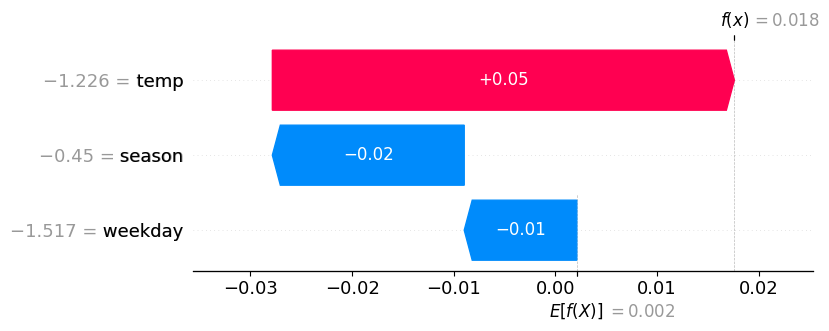

In [21]:
# Use Universal Explainer
explainer_kernel = shap.Explainer(model, X_train_scaled)

shap_values = explainer_kernel(X_test_scaled)
print("Local explanations:")
for feature, value in zip(model.feature_names_in_, shap_values.values[0]):
    print(f"{feature}: {value:.4f}")

shap.waterfall_plot(shap_values[0])

Similar to a waterfall plot is a force plot. The ideas are the same, except instead of a waterfall, all the SHAP values are depicted in a single line, with sizes related to the SHAP values, centered at the average prediction. In the same way that the waterfall depicts each feature’s contributions, the force plot shows how each feature adds or subtracts from the average prediction to reach the final prediction. 

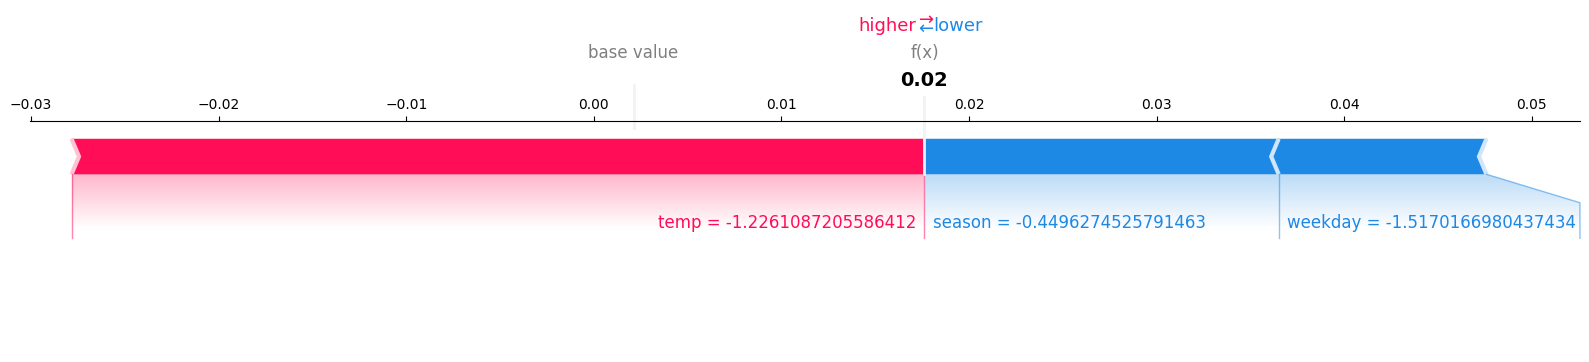

In [22]:
shap.initjs()
shap.force_plot(
    explainer_kernel.expected_value, shap_values.values[0], X_test_scaled.iloc[0], matplotlib=True
)

In these examples, we used a regression model and corresponding SHAP values. Hence, the SHAP values are in units of our target variable (here, bike rental counts). For classification problems, the units will be logits or probability space, depending on how the explainer is defined.

The waterfall plot will have values in the logit space. This is due to passing the model itself into the “universal” explainer (which, behind the scenes, is using `LinearExplainer` on a linear model).

On the other hand, we can instead use the predicted probabilities, `model_c.predict_proba`, in the explainer.

#### **Global Explanations**

From the last few exercises, we used the mean absolute SHAP values as a global interpretation of the importance of the features. While this gives a single value for each feature, it removes details regarding the sign of the impact: Do higher temperatures increase or decrease bike rentals? In our linear regression model, we have used the following output to compute global importance:

In [23]:
import shap

explainer_kernel = shap.Explainer(model, X_train_scaled)
shap_values = explainer_kernel(X_test_scaled)

print("\nGlobal explanations:")
shap_values_importance = np.abs(shap_values.values).mean(0)
for feature, value in zip(model.feature_names_in_, shap_values_importance):
    print(f"{feature}: {value:.4f}")


Global explanations:
temp: 0.0315
season: 0.0374
weekday: 0.0064


We could visualize this with a bar chart, but this plot is built into the SHAP library! To use, we can call `shap.plots.bar()` on the SHAP values:

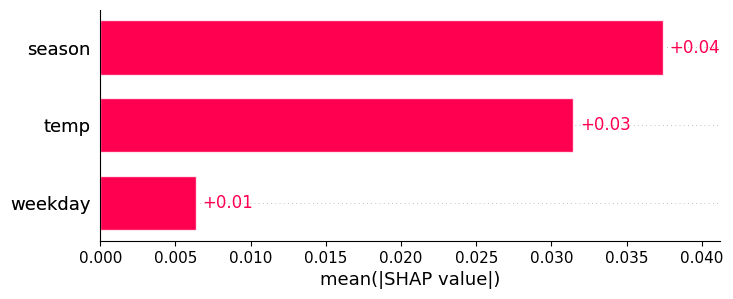

In [24]:
shap.plots.bar(shap_values)

 While this can be useful to determine the most important features, we need more information about the nature of the impact. Because of this, bee swarm plots can be pretty useful in visualizing global insights into the SHAP values but also contain individual data points color-coded by their relative values. Let’s check it out!

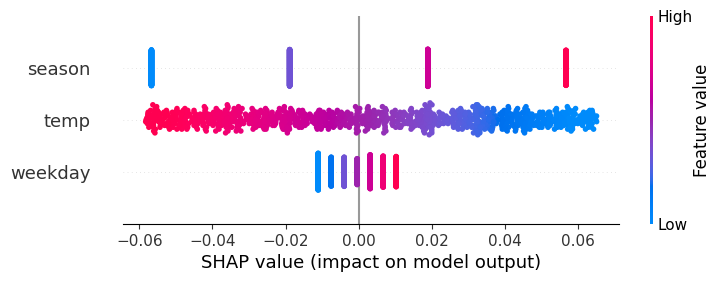

In [25]:
shap.plots.beeswarm(shap_values)

For each feature, there is a point representing each data point with its x-value determined by its SHAP value. Its value is represented by color. For temp, for example, we already knew from the bar plot this has the most significant impact globally – from the swarm plot, we can get a better sense of the sign of the effect. As we move along the x-axis from left to right, the temp colors go from blue to red – they are increasing. This means that SHAP values increase as temperature increases. Hotter temperatures tend to increase the number of bike rentals, while colder temperatures decrease the number of bike rentals. Since weekdays and seasons are categorical features, seeing individual points is harder. Still, they are clustered in their categories and show a positive relationship – as weekday and season values increase, the SHAP values also increase.

#### **SHAP Dependence Plots**

Now that we’ve explored local and global explanations using SHAP values, let’s visualize how features interact with predictions. SHAP provides powerful tools, including dependence plots and partial dependence plots. These plots help us understand which features are important and how they influence predictions.

A dependence plot shows how the SHAP value of a specific feature changes with its value. It is essentially a scatter plot where the x-axis represents the values of a specific feature, and the y-axis represents the SHAP values for that feature, showing its contribution to the model’s predictions. Using color to represent a second feature, a dependence plot can highlight potential interactions with other features.

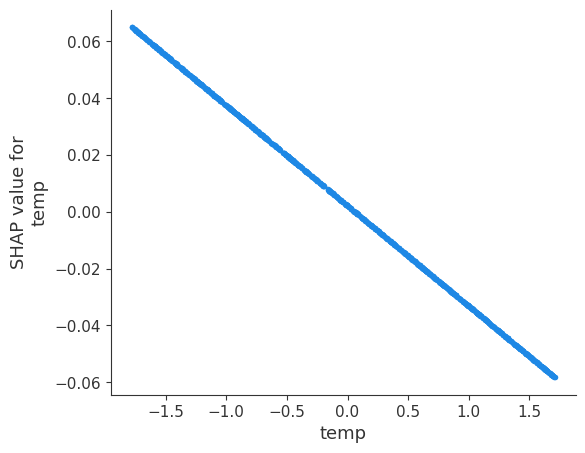

In [26]:
# Plot dependence for the 'temp' feature
shap.dependence_plot(
    "temp",
    shap_values.values,
    X_test_scaled,
    feature_names=model.feature_names_in_,
    interaction_index=None,
)

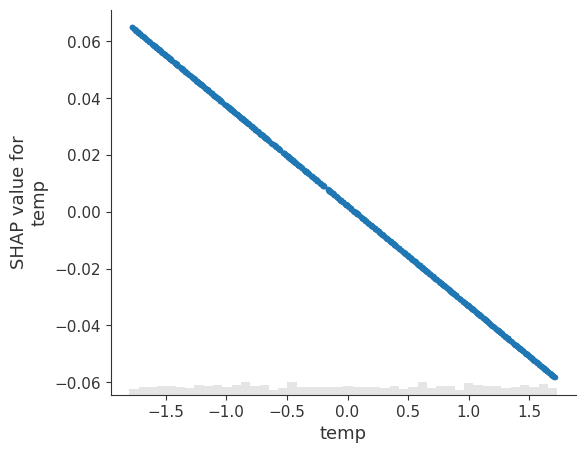

In [27]:
shap.plots.scatter(shap_values[:, "temp"], color=None)

SHAP dependence plots can use color to reveal potential interactions between features. For example, the color might represent the value of season, showing how it influences the relationship between temp and bike rentals.

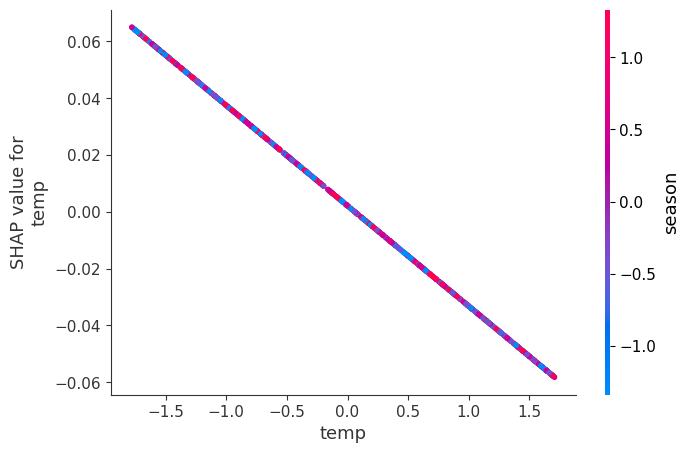

In [28]:
# Plot dependence with interaction effects highlighted
shap.dependence_plot(
    "temp",
    shap_values.values,
    X_test_scaled,
    feature_names=model.feature_names_in_,
    interaction_index="season",
)

- Red/blue points: The color reflects the value of another feature (e.g., season), which can show interaction effects. Blue points represent when the season is winter, which mostly corresponds to negative SHAP values and negative temp values.
- Trends: You might observe that the relationship between temp and bike rentals changes depending on the value of the interaction feature.

#### **SHAP Partial Dependence Plots**

While dependence plots show the SHAP values directly, partial dependence plots (PDP) look at the model’s predictions. A partial dependence plot reveals how the predictions change when you vary one feature while holding others constant. SHAP makes it simple to create PDPs. Using temp again, we can use `shap.plots.partial_dependence`:

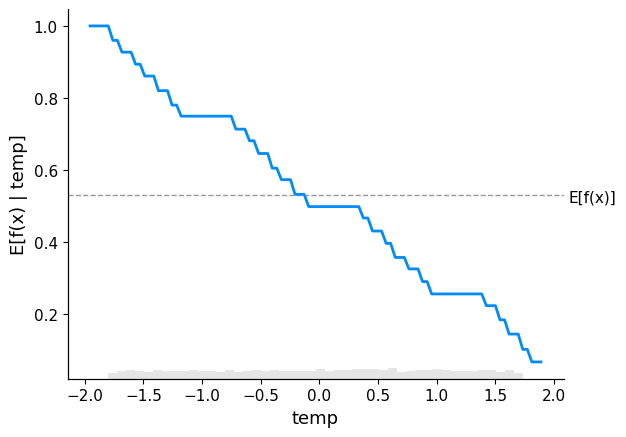

In [29]:
shap.plots.partial_dependence(
    "temp", model.predict, X_train_scaled, ice=False, model_expected_value=True
)

- The x-axis represents the feature value (temp).
- The y-axis represents the model’s predicted outcome (e.g., bike rentals).
- `ice=False` ensures we generate a single PDP line instead of individual conditional expectation lines. 
- The plot shows whether predictions increase, decrease, or remain constant as temp changes.
- If temp has a linear relationship with bike rentals, you might see a steady increase or decrease.

## **LIME**

How Does Local Interpretable Model-agnostic Explanations (LIME) Work? Let’s break it down step by step with an example:

1. Pick an Instance: Start with one prediction you want to explain. For example, let’s say the model predicted 4,933 bike rentals on a given day.
2. Create perturbed instances: LIME slightly changes the day’s features (like the temp, season and weekday) to make perturbed instances of the daily features.
3. Get Predictions: Generate the predicted bike rentals for these perturbed instances using the original model.
4. Build a Simple Model: LIME uses these perturbed instances and their predictions to create a simple, local model (like a linear regression) that’s easy to understand.
5. Explain the Prediction: The simple model shows which features (like temp or season) are most important (using the coefficients of the linear regression model) for the 4,933 bike rentals.

In summary, LIME is simpler and faster because it doesn’t try to explain the model on the entire dataset, just the prediction for one instance. By focusing on one example, LIME gives clear, simple explanations. SHAP is more robust and applicable to global explanations but computationally intensive. The choice between them depends on your specific use case, computational constraints, and the level of detail required. 

1. Start with one prediction you want to explain. The first row of the test data will be our point of reference. Using , we can see that the predicted number of bike rentals is 4973 (since the model was trained on the scaled data). We want to explain how the features `temp`, `season`, and `weekday` influenced this prediction.


In [30]:
X_row = X_test_scaled.iloc[0]
model.predict(X_row.values.reshape(1, -1))

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

2. LIME slightly changes the day’s features (like the `temp`, `season`, and `weekday`) to make perturbed instances of the daily features. A perturbation means making small changes to the input data (e.g., slightly modifying a feature value) to observe how the model’s prediction changes. `temp` is a continuous feature, while `season` and `weekday` are discrete. Our perturbation method will change depending on the feature type. For continuous features, we will add a random number, following a normal distribution, to the original value:


In [31]:
# Number of perturbed samples to generate
n_perturbations = 500

# Perturb the continuous variable
continuous_perturbations = np.random.normal(
    loc=float(X_row[0]), scale=1, size=(n_perturbations, 1)
)

# Perturb the categorical variables by random sampling
categorical_perturbations = np.zeros((n_perturbations, len(X_row) - 1), dtype=object)
for i, col in enumerate(range(1, len(X_row))):  # Iterate over categorical columns
    categorical_perturbations[:, i] = np.random.choice(
        X_train_scaled.iloc[:, col].values, size=n_perturbations
    )

C:\Users\mervedosa\AppData\Local\Temp\ipykernel_27188\345016172.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loc=float(X_row[0]), scale=1, size=(n_perturbations, 1)


For discrete features, the perturbation will instead pick a value from the training set distribution of values for that feature:

```python
categorical_perturbations[:, i] = np.random.choice(X_train_scaled.iloc[:,col].values, size=n_perturbations)
```

3. Generate the predicted bike rentals for these perturbed instances using the original model. Once the perturbations for each feature are combined, the predictions for the perturbed dataset are obtained using the original model:

In [32]:
# Combine perturbed continuous and categorical variables
perturbed_data = np.hstack([continuous_perturbations, categorical_perturbations])
model.predict(perturbed_data)

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True, False,
        True,  True,

4. Use these perturbed instances and their predictions to create a ridge regression model with weighting. The weights are computed using the Euclidean distance of the perturbations from the original data point and then applying an exponential kernel:

In [33]:
# import RidgeRegression model
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import euclidean_distances

In [34]:
# Calculate distances (use only continuous variables for distance calculation)
distances = euclidean_distances(continuous_perturbations, [[float(X_row[0])]])

# Calculate kernel weights (LIME uses an exponential kernel)
kernel_width = 2
weights = np.sqrt(np.exp(-(distances**2) / kernel_width**2))

# Fit a local weighted linear model on continuous perturbed data
alpha = 0.001  # Small regularization strength to match LIME's behavior
local_model = Ridge(alpha=alpha)
local_model.fit(perturbed_data, model.predict(perturbed_data), sample_weight=weights.flatten())

C:\Users\mervedosa\AppData\Local\Temp\ipykernel_27188\3837061501.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distances = euclidean_distances(continuous_perturbations, [[float(X_row[0])]])
c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,alpha,0.001
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


5. The simple model shows the most important features. The local model can be interpreted in terms of its coefficient values near the reference data point. For small perturbations, the coefficients can be interpreted as the change in bike rentals per unit change of each feature.


In [35]:
# Extract feature importance from the linear model
manual_lime_explanation = dict(zip(X_train_scaled.columns, local_model.coef_))

print(f"Original datapoint: {X_test.iloc[0].round(1)}")

Original datapoint: temp       0.2
season     2.0
weekday    0.0
Name: 1501, dtype: float64


In [36]:
print(f"Original model prediction: {model.predict(X_test_scaled.iloc[0].values.reshape(1,-1))}")

Original model prediction: [ True]


c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [37]:
print("Unscaled Perturbed Data:\n", scaler.inverse_transform(perturbed_data)[:5])

Unscaled Perturbed Data:
 [[ 0.57847061  4.          3.        ]
 [ 0.53392531  1.          5.        ]
 [-0.15776055  1.          6.        ]
 [-0.02718014  3.          4.        ]
 [ 0.54009005  1.          0.        ]]


In [38]:
# Display manual LIME explanation
print("\nManual LIME explanation:")
for feature, value in manual_lime_explanation.items():
    print(f"{feature}: {value:.4f}")


Manual LIME explanation:
temp: -0.1961
season: 0.2211
weekday: 0.0436



For this local instance, the `temp` has the largest LIME value, followed by `season` and wee`kday. Still, all coefficients are positive, indicating that increases in these values increase the target variable.

### **LimeTabularExplainer**

The LIME library has three main types of explainers, which depend on the dataset type: tabular, text, or images. For tabular data, the explainer, `LimeTabularExplainer`, is imported from `lime.lime_tabular`. The explainer is initialized by passing in the training data and mode (classification or regression) with the following code:

In [39]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    mode="regression",
    feature_names=X_train_scaled.columns.tolist(),
    discretize_continuous=False,
)

To match our manual LIME calculation, we will use `discretize_continuous=False`. LIME allows the discretization, or binning, of continuous features to simplify explanations, which we will demonstrate shortly. Now that we’ve set up the `LimeTabularExplainer`, we can generate explanations for individual predictions by passing in the data row and predict function:

In [40]:
lime_exp = explainer.explain_instance(
    data_row=X_row,  # The sample to explain
    predict_fn=model.predict,  # The model’s prediction function
)

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


To access the LIME values for the explanation object, we can convert to a list and print the values:

In [41]:
# Get LIME explanation from the library
lime_library_explanation = dict(lime_exp.as_list())
# Output the LIME library explanation
print("\nLIME library explanation:")
for feature, value in lime_library_explanation.items():
    print(f"{feature}: {value:.4f}")


LIME library explanation:
season: 0.3813
temp: -0.3004
weekday: 0.0712


here will always be some differences due to the randomness of the perturbations and approximation methods. Regarding interpretations, we found all features positively contributed to the prediction, with the temp being the largest. However, the sum of LIME values does NOT have a meaning, so do not assume the sum of the LIME values equals the difference in the model prediction and average prediction.

### **LIME Visuals**

We can visualize the explanation using LIME’s built-in plotting functions for tabular explainers within a notebook by calling `lime_exp.show_in_notebook()`. Also available are options to save the figure as a pyplot object, `lime_exp.as_pyplot_figure()` or a stand-alone HTML file, `lime_exp.save_to_file(file)`.

In [42]:
import matplotlib.pyplot as plt

lime_exp.show_in_notebook(show_table=True, show_all=False)  # Display the explanation in a notebook

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\IPython\core\display.py)

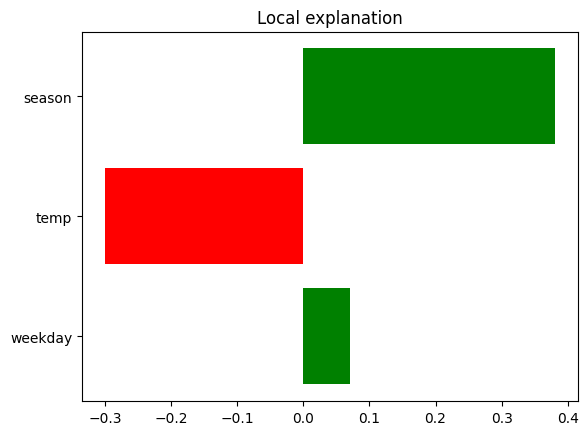

In [43]:
lime_exp.as_pyplot_figure()
plt.show()

### **Classification Models**

Now that we’ve seen how LIME can be used for regression models, we will explore modifications needed for classification tasks! We will start with an already fit logistic regression model, which predicts whether the bike rentals are above or below the mean on a given day. Much of the setup is the same as we saw in regression problems – we initialize a LIME tabular explainer with the training data set, but now using `mode='classification'` and specifying the class_names:

In [44]:
# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train_scaled,
    mode="classification",
    discretize_continuous=False,
    feature_names=X_train_scaled.columns,
    class_names=["below_median", "above_median"],
)

Now, if the model returns predicted probabilities (like with the method `.predict_proba()` in many scikit-learn models), this can be used to generate explanations for a given instance by passing the data point and `model.predict_proba` to `explainer.explain_instance()`:

In [45]:
lime_exp = explainer.explain_instance(X_row, model.predict_proba)

c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [46]:
lime_exp.show_in_notebook()

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\mervedosa\OneDrive - Deloitte (O365D)\Documents\Deloitte\Non-Billable\Azure\crm_codelib\UK SRTA CRM Credit Library\.venv\Lib\site-packages\IPython\core\display.py)

# **Extra Reading**

https://medium.com/biased-algorithms/shap-values-explained-08764ab16466

https://medium.com/data-reply-it-datatech/explainable-ai-shap-values-1c7128ef06c2

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/

https://towardsdatascience.com/shap-how-to-interpret-machine-learning-models-with-python-2323f5af4be9/

https://medium.com/data-science/lime-explain-machine-learning-predictions-af8f18189bfe

https://huggingface.co/blog/sentiment-analysis-python

https://medium.com/data-science/shap-explain-any-machine-learning-model-in-python-72f0bea35f7c

